# Overview
- kaggleのNotebook(BERT CARREMANS氏)を参考に、1)データ読込、2)可視化、3)加工を実施。
- 3)のデータ加工は、(1)目的変数の不均衡対策としてのUndersampling、(2)欠損値補完、(3)ダミー変数作成、(4)交互作用特徴量の作成、(5)Random Forest重要特徴量による特徴量選択、を実施。
- 参考: Data Preparation & Exploration, BERT CARREMANS, https://www.kaggle.com/code/bertcarremans/data-preparation-exploration/notebook

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

## 1) データ読込

In [2]:
#df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv')   # Google Colabの場合はこちら
data_train = pd.read_csv('C:/Users/ultra/Documents/GitHub/data/220417_kaggle_Practice_Porto-Seguro-s-Safe-Driver-Prediction/train.csv')   # ローカルの場合はこちら
data_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [3]:
#df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/test.csv')   # Google Colabの場合はこちら
data_test = pd.read_csv('C:/Users/ultra/Documents/GitHub/data/220417_kaggle_Practice_Porto-Seguro-s-Safe-Driver-Prediction/test.csv')   # ローカルの場合はこちら
data_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [4]:
print('train data: ', np.shape(data_train))
print('test data: ', np.shape(data_test))
print('')
print(data_train.info())

train data:  (595212, 59)
test data:  (892816, 58)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_i

### 1.1) データをメタ化する

In [5]:
# 'meta'というDataFrameに、各columnについて以下カテゴリの分類結果を入れる
# 'role': target, id, input
# 'level': binary, categorical, continuous, ordinal
# 'keep': True except 'id'
# 'dtype': int, float, str


data = []

for f in data_train.columns:
    # 'role'分類
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    # 'level'分類
    if 'bin' in f or f == 'target':
        level = 'binary'   # バイナリ変数（0か1）のデータ
    elif 'cat' in f or f == 'id':
        level = 'categorical'   # カテゴリ変数のデータ
    elif data_train[f].dtype == float:
        level = 'continuous'   # 浮動小数点のノーマルデータ
    #elif data_train[f].dtype == int:
    else:
        level = 'ordinal'   # 整数のノーマルデータ
    
    # 'keep'分類
    keep = True
    if f == 'id':
        keep = False
    
    # 'dtype'分類
    dtype = data_train[f].dtype
    
    # Dict形式にする
    f_dict = {
        'varname': f, 'role': role, 'level': level, 'keep': keep, 'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,categorical,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,categorical,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,categorical,True,int64
ps_ind_05_cat,input,categorical,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [6]:
# 各levelに該当する説明変数の数をカウント

pd.DataFrame({'count': meta.groupby(['role','level'])['role'].count()}).reset_index()

,role,level,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,continuous,10
4,input,ordinal,16
5,target,binary,1


### 1.2) データ全体の描写

In [7]:
# 'continuous'変数を詳しく見る
# ---------------------------

v = meta[(meta['level'] == 'continuous') & (meta['keep'] == True)].index
data_train[v].describe()

# --------------------------
# 'reg'
# ・ps_reg_03のみ欠損値(-1)あり
# ・変数の範囲に違いがあるため、スケーリングを検討
#
# 'car'
# ・ps_car_12とps_car_14に欠損値(-1)あり
# ・変数の範囲に違いがあるため、スケーリングを検討
#
# 'calc'
# ・欠損値なし
# ・変数範囲は0～0.9で一致
# ・平均値、標準偏差がほぼ等しく、似た分布と思われる
# --------------------------

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [8]:
# 'ordinal'変数を詳しく見る
# --------------------------

v = meta[(meta['level'] == 'ordinal') & (meta['keep'] == True)].index
data_train[v].describe()

# --------------------------
# 'ind'
# ・欠損値なし
# ・変数の範囲に違いがあるため、スケーリングを検討
#
# 'car'
# ・唯一の変数であるps_car_11に欠損値(-1)あり
#
# 'calc'
# ・欠損値なし
# ・変数の範囲に違いがあるため、スケーリングを検討
# --------------------------

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [9]:
# 'binary'変数を詳しく見る
# --------------------------

v = meta[(meta['level'] == 'binary') & (meta['keep'] == True)].index
data_train[v].describe()

# --------------------------
# 'target'
# ・欠損値なし
# ・平均0.0364のため、0に比べて1が極端に少ない(3.64%)
#
# 'ind'
# ・欠損値なし
# ・ps_ind_10、ps_ind_11、ps_ind_12、ps_ind_13は0に比べて1が極端に少ない
#
# 'calc'
# ・欠損値なし
# --------------------------

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.3) 欠損データの確認

In [10]:
vars_missing = []

for f in data_train.columns:
    n_missing = data_train[data_train[f] == -1][f].count()
    
    if n_missing > 0:
        vars_missing.append(f)
        perc_missing = n_missing / data_train.shape[0]
        print('Variable {} has {} records ({:.2%})'.format(f, n_missing, perc_missing)
              + ' with missing values')
        
print('In total, there are {} missing variables'.format(len(vars_missing))
      + ' with missing values')

# ----------------------------------
# ・ps_car_03_cat、ps_car_05_catは特に欠損値の割合が大きい => 変数自体を取り除く
# ・ps_reg_03は18％が欠損値 => 'continuous'なのでmeanで置き換える
# ・その他欠損値も'continuous'はmean、'ordinal'はmodeで置き換える
# ----------------------------------

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 missing variables with missing values


### 1.4) categorical変数の一意なデータ数の確認

In [11]:
v = meta[(meta['level'] == 'categorical') & (meta['keep'] == True)].index

for f in v:
    dist_values = data_train[f].value_counts().shape[0]
    print('Varaiables {} has {} distinct values'.format(f, dist_values))
    
# ----------------------------------
# ・ps_car_11_catのみ極端に一意なデータ数が多い
# ----------------------------------

Varaiables ps_ind_02_cat has 5 distinct values
Varaiables ps_ind_04_cat has 3 distinct values
Varaiables ps_ind_05_cat has 8 distinct values
Varaiables ps_car_01_cat has 13 distinct values
Varaiables ps_car_02_cat has 3 distinct values
Varaiables ps_car_03_cat has 3 distinct values
Varaiables ps_car_04_cat has 10 distinct values
Varaiables ps_car_05_cat has 3 distinct values
Varaiables ps_car_06_cat has 18 distinct values
Varaiables ps_car_07_cat has 3 distinct values
Varaiables ps_car_08_cat has 2 distinct values
Varaiables ps_car_09_cat has 6 distinct values
Varaiables ps_car_10_cat has 3 distinct values
Varaiables ps_car_11_cat has 104 distinct values


## 2) データ可視化

### 2.1) categoricalデータの可視化

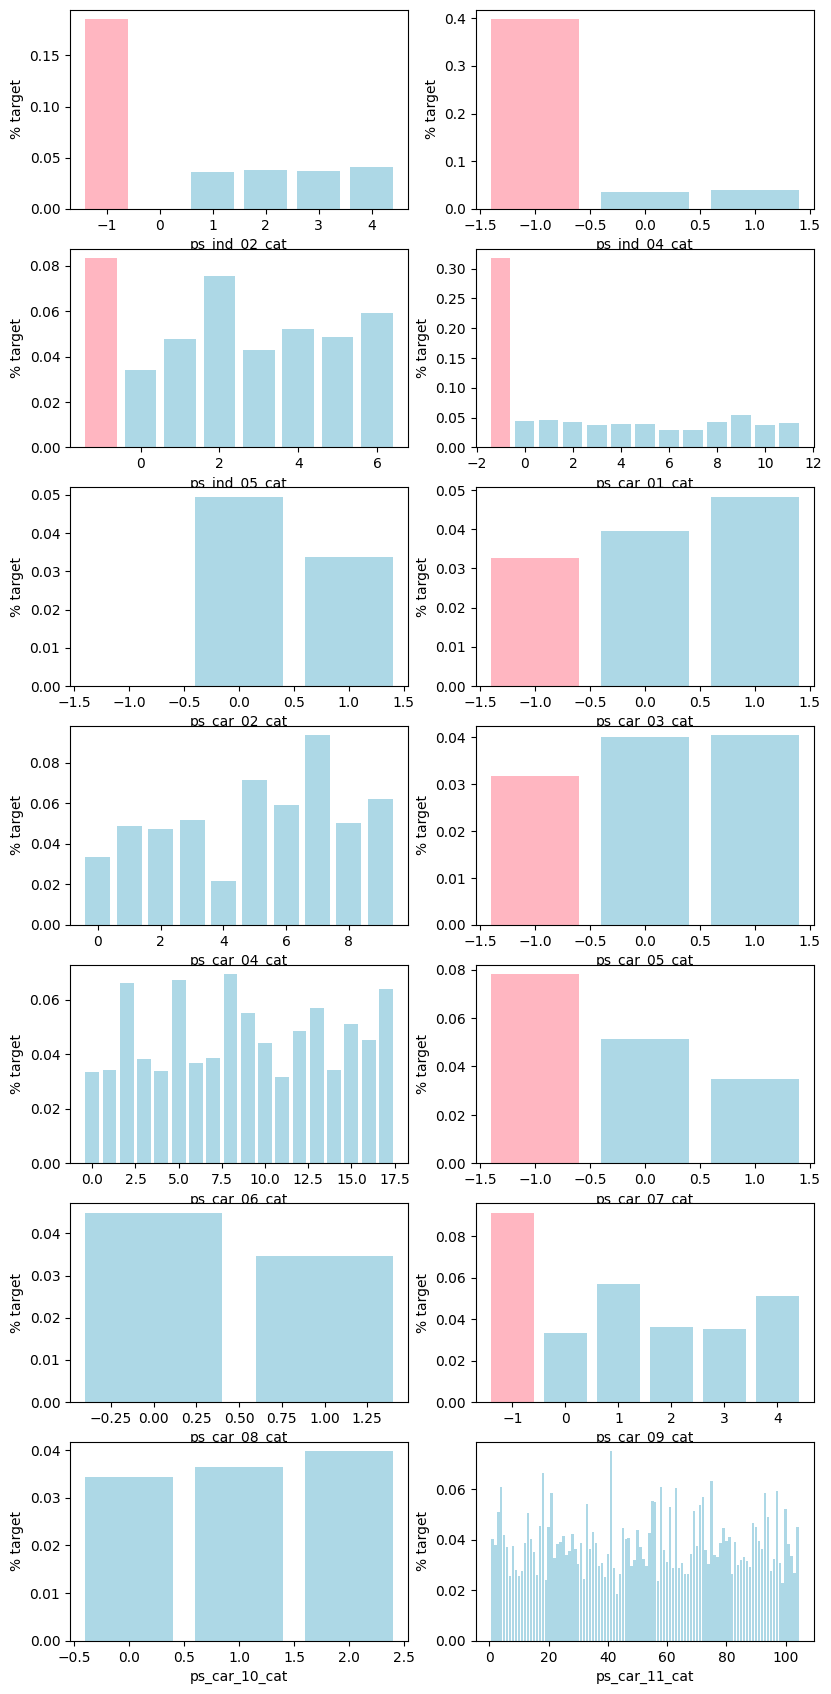

In [12]:
# 各categoricalデータにおいて、値ごとの
# 「'target'の平均」=「'target'=1である確率」をグラフ化
# ------------------------------------------------------

v = meta[(meta['level'] == 'categorical') & (meta['keep'] == True)].index

vs = v.size
row = int(np.ceil(vs / 2))

i = 1
fig = plt.figure(figsize=(9.6, 21.6), dpi=100)

for f in v:
    ax = fig.add_subplot(row, 2, i, xlabel=f, ylabel='% target')
    
    # 各データでの'target'平均値を計算
    cart_perc = data_train[[f, 'target']].groupby([f], as_index=False).mean()
    cart_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # グラフに出力
    X = cart_perc[f]
    Y = cart_perc['target']
    color = [('lightpink' if i==-1 else 'lightblue') for i in X]
    ax.bar(X, Y, color=color)   # 欠損値のみピンクで出力する

    i += 1

    
# ------------------------------------------------
# 欠損値が'target'=1に寄与している変数が多いことがわかる
# ------------------------------------------------

### 3.2) continuousデータの可視化

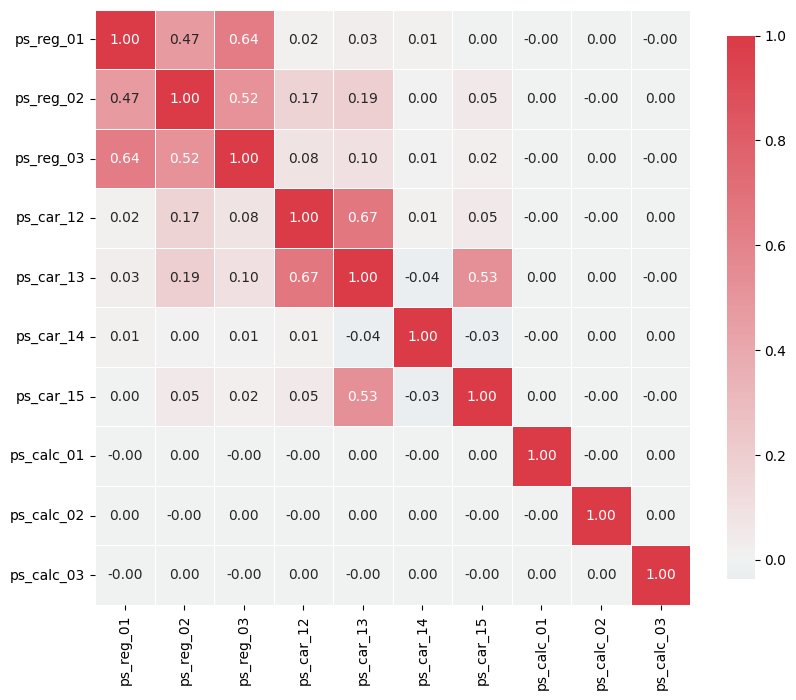

In [13]:
# 各continuousデータの相関を可視化
# ---------------------------------

def corr_heatmap(v):
    correlations = data_train[v].corr()
    
    # カラーマップの作成
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig = plt.figure(figsize=(9.6, 9.6), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})

    
v = meta[(meta['level'] == 'continuous') & (meta['keep'] == True)].index
corr_heatmap(v)


# -------------------------------------
# ・'ps_reg_02'と'ps_reg_03'の相関0.7
# ・'ps_car_!2'と'ps_car_13'の相関0.67
# ・'ps_car_12'と'ps_car_14'の相関0.58
# ・'ps_car_13'と'ps_car_15'の相関0.53
# -------------------------------------

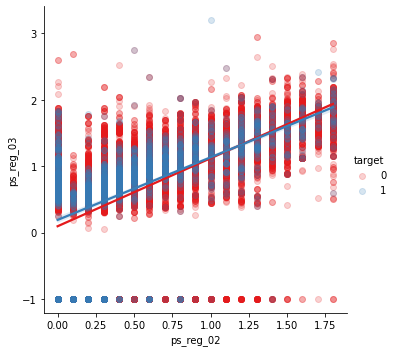

In [14]:
# 高速化のため10%のデータをランダムに抽出
s = data_train.sample(frac=0.1)


# 'ps_reg_02'と'ps_reg_03'をプロット
# -----------------------------------

sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

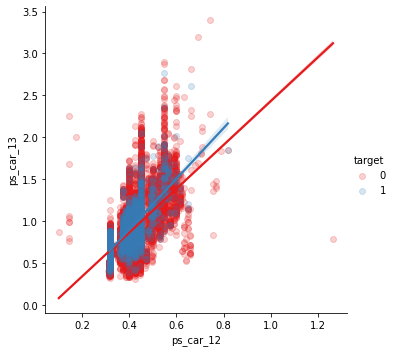

In [15]:
# 'ps_car_12'と'ps_car_13'をプロット
# -----------------------------------

sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

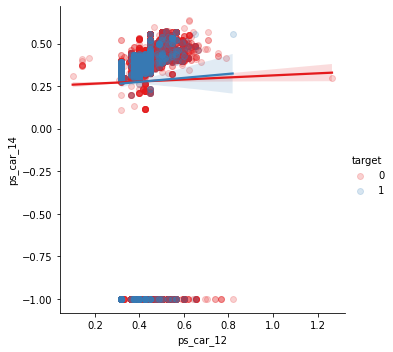

In [16]:
# 'ps_car_12'と'ps_car_14'をプロット
# -----------------------------------

sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

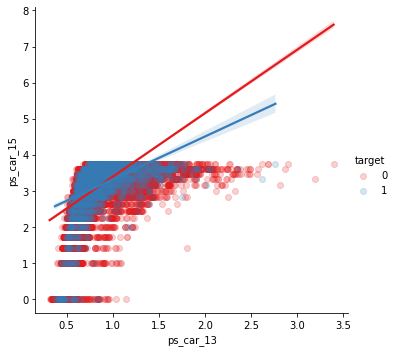

In [17]:
# 'ps_car_13'と'ps_car_15'をプロット
# -----------------------------------

sns.lmplot(x='ps_car_13', y='ps_car_15', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

### 3.3) ordinalデータの可視化

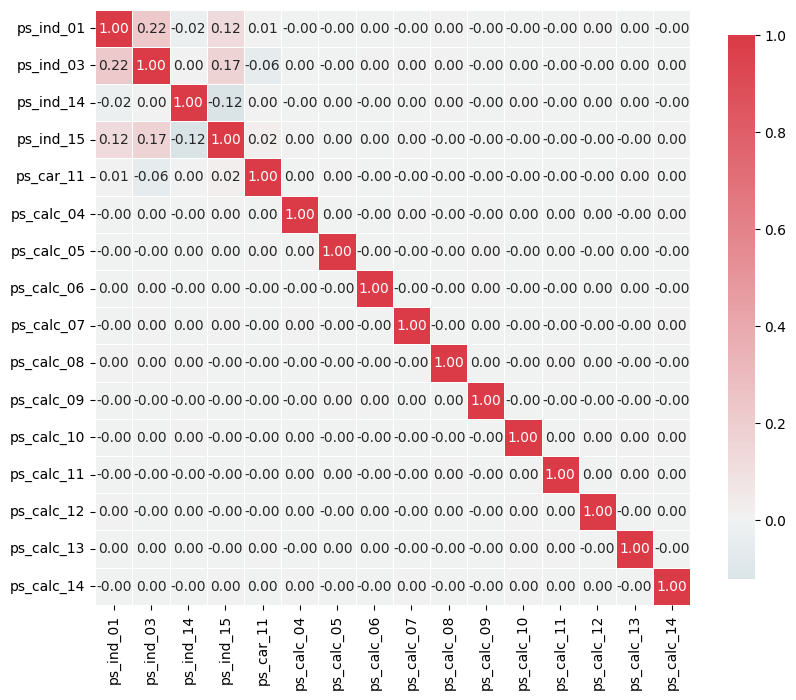

In [18]:
# 各ordinalデータの相関を可視化
# -------------------------------

v = meta[(meta['level'] == 'ordinal') & (meta['keep'] == True)].index
corr_heatmap(v)


# -----------------------------------------
# 'ordinal'データは互いに相関はほとんどない
# -----------------------------------------

## 3) データ加工

### 3.1) target変数の不均衡対策

In [19]:
# 1.2)で見たように'target'内で1の割合が極端に少ない
# 対策として0をundersamplingして相対的に0と1の割合差を小さくする
# --------------------------------------------------------------

desired_apriori = 0.10   # 全体に対して1がこの割合になるよう0をundersampleする

# 0と1のindexを取得
idx_0 = data_train[data_train['target'] == 0].index
idx_1 = data_train[data_train['target'] == 1].index

nb_0 = len(idx_0)
nb_1 = len(idx_1)

# undersampling rateを計算
undersampling_rate = ((1 - desired_apriori) * nb_1) / ((desired_apriori) * nb_0)
undersampled_nb_0 = int(undersampling_rate * nb_0)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undrsampling: {}'.format(undersampled_nb_0))

# 'target'=0のデータを必要な数だけランダムに選択する
undersampled_idx = shuffle(idx_0, random_state=21, n_samples=undersampled_nb_0)

# 'target'=0および1のリストを作成する
idx_list = list(undersampled_idx) + list(idx_1)

# undersampleしたデータを取り出す
train = data_train.loc[idx_list].reset_index(drop=True)
train_w_nan = train.copy()   # 欠損値ありのものをコピーしておく
train

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undrsampling: 195246


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1217739,0,0,1,7,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.3,0.0,-1.000000,6,1,-1,0,1,15,1,1,0,1,5,2,0.447214,1.158761,0.400000,3.605551,0.2,0.5,0.5,1,1,8,2,9,2,7,8,1,3,8,0,1,1,0,1,0
1,949437,0,7,2,2,0,0,1,0,0,0,0,0,0,0,0,10,1,0,0,0.9,0.4,0.860233,11,0,1,0,1,11,1,1,2,1,104,3,0.447214,0.896976,0.366742,3.162278,0.0,0.5,0.7,3,3,9,2,5,2,8,6,0,4,9,0,1,0,1,0,0
2,1252456,0,1,1,3,1,0,1,0,0,0,0,0,0,0,0,6,1,0,0,0.7,0.2,0.590551,6,1,-1,0,0,1,1,1,0,1,64,3,0.316228,0.683150,0.361939,3.464102,0.1,0.9,0.9,2,0,8,2,9,3,11,7,0,2,9,0,0,0,1,1,0
3,1092237,0,4,2,2,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0.9,1.5,1.468843,11,1,0,0,0,7,1,1,2,1,92,3,0.374166,0.768289,0.327872,3.316625,0.1,0.9,0.3,1,1,6,4,11,3,5,9,2,2,9,0,0,1,0,0,0
4,902487,0,4,2,3,1,0,0,1,0,0,0,0,0,0,0,7,1,0,0,0.6,0.4,0.787798,6,1,-1,0,1,10,1,1,0,1,28,3,0.387298,1.070269,0.382099,3.741657,0.7,0.8,0.0,3,3,8,2,11,3,8,4,2,2,9,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,1487473,1,5,1,7,0,3,0,0,1,0,0,0,0,0,0,8,0,1,0,0.6,0.4,1.537652,11,0,0,0,1,5,1,1,2,1,104,1,0.424264,1.269111,0.384708,3.162278,0.5,0.1,0.5,3,4,9,1,10,2,9,10,1,5,7,0,1,1,0,0,0
216936,1487566,1,1,1,5,0,0,0,0,1,0,0,0,0,0,0,4,0,0,1,0.3,0.4,-1.000000,11,0,-1,0,-1,15,1,1,2,1,5,2,0.424264,0.756979,0.400000,2.000000,0.3,0.4,0.6,1,1,8,2,9,5,9,9,2,1,5,0,1,0,0,0,0
216937,1487716,1,0,1,6,1,0,0,1,0,0,0,0,0,0,0,9,0,1,0,0.9,0.3,0.711952,11,1,0,0,1,7,1,1,1,1,104,3,0.400000,0.970654,0.372424,3.464102,0.5,0.4,0.6,2,2,8,2,8,4,10,3,2,1,6,0,1,1,0,0,0
216938,1487748,1,0,2,2,0,0,1,0,0,0,0,0,0,0,0,2,0,0,1,0.6,0.1,0.577170,7,1,1,0,0,11,1,0,2,1,104,2,0.316228,0.876295,0.320780,3.741657,0.5,0.2,0.6,3,0,9,3,10,4,11,5,0,4,4,0,0,1,0,1,0


### 3.2) 欠損値処理

In [20]:
# 欠損値の割合が大きい ps_car_03_cat、ps_car_05_cat を取り除く
# -----------------------------------------------------------

vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
if np.size(train, axis=1) == 59:
    train.drop(vars_to_drop, inplace=True, axis=1)

# 'meta'をアップデートしておく
meta.loc[(vars_to_drop), 'keep'] = False


# 欠損値にmean またはmodeを代入する
# ----------------------------------

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

vars_to_mean = ['ps_reg_03', 'ps_car_12', 'ps_car_14']
mean_imp.fit(train[(vars_to_mean)])
train[(vars_to_mean)] = mean_imp.transform(train[(vars_to_mean)])

vars_to_mode = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
                'ps_car_02_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11']
mode_imp.fit(train[(vars_to_mode)])
train[(vars_to_mode)] = mode_imp.transform(train[(vars_to_mode)])


# 欠損値がなくなったか確認
# -------------------------

vars_missing = []

for f in train.columns:
    n_missing = train[train[f] == -1][f].count()
    
    if n_missing > 0:
        vars_missing.append(f)
        perc_missing = n_missing / train.shape[0]
        print('Variable {} has {} records ({:.2%})'.format(f, n_missing, perc_missing)
              + ' with missing values')
        
print('In total, there are {} missing variables'.format(len(vars_missing))
      + ' with missing values')

In total, there are 0 missing variables with missing values


### 3.3) categorical変数のダミー化

In [21]:
v = meta[(meta['level'] == 'categorical') & (meta['keep'] == True)].index
print('Before dummification, we have {} variables in train data'.format(train.shape[1]))

train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification, we have {} variables in train data'.format(train.shape[1]))


Before dummification, we have 57 variables in train data
After dummification, we have 204 variables in train data


### 3.4) continuous変数のべき乗および交互作用の特徴量を作成

In [22]:
v = meta[(meta['level'] == 'continuous') & meta['keep'] == True].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]),
                            columns=poly.get_feature_names(v))

# オリジナル(一次)の特徴量は重複となるので削除
interactions.drop(v, axis=1, inplace=True)

print('Before creating interactions, we have {} variables in train data'.format(train.shape[1]))

train = pd.concat([train, interactions], axis=1)
print('After creating interactions, we have {} variables in train data'.format(train.shape[1]))

interactions.head()

Before creating interactions, we have 204 variables in train data
After creating interactions, we have 259 variables in train data


,ps_reg_01^2,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0.09,0.00,0.269296,0.134164,0.347628,0.120000,1.081665,0.06,0.15,0.15,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.805782,0.401443,1.040166,0.359061,3.236535,0.179531,0.448827,0.448827,0.20,0.518214,0.178885,1.612452,0.089443,0.223607,0.223607,1.342727,0.463504,4.177973,0.231752,0.579381,0.579381,0.1600,1.442221,0.080000,0.200000,0.200000,13.0,0.721110,1.802776,1.802776,0.04,0.10,0.10,0.25,0.25,0.25
1,0.81,0.36,0.774209,0.402492,0.807278,0.330068,2.846050,0.00,0.45,0.63,0.16,0.344093,0.178885,0.358790,0.146697,1.264911,0.00,0.20,0.28,0.740000,0.384708,0.771608,0.315484,2.720294,0.000000,0.430116,0.602163,0.20,0.401140,0.164012,1.414214,0.000000,0.223607,0.313050,0.804566,0.328959,2.836487,0.000000,0.448488,0.627883,0.1345,1.159741,0.000000,0.183371,0.256720,10.0,0.000000,1.581139,2.213594,0.00,0.00,0.00,0.25,0.35,0.49
2,0.49,0.14,0.413385,0.221359,0.478205,0.253357,2.424871,0.07,0.63,0.63,0.04,0.118110,0.063246,0.136630,0.072388,0.692820,0.02,0.18,0.18,0.348750,0.186748,0.403435,0.213743,2.045727,0.059055,0.531496,0.531496,0.10,0.216031,0.114455,1.095445,0.031623,0.284605,0.284605,0.466694,0.247259,2.366502,0.068315,0.614835,0.614835,0.1310,1.253794,0.036194,0.325745,0.325745,12.0,0.346410,3.117691,3.117691,0.01,0.09,0.09,0.81,0.81,0.81
3,0.81,1.35,1.321959,0.336749,0.691460,0.295085,2.984962,0.09,0.81,0.27,2.25,2.203265,0.561249,1.152434,0.491808,4.974937,0.15,1.35,0.45,2.157500,0.549591,1.128497,0.481592,4.871601,0.146884,1.321959,0.440653,0.14,0.287468,0.122678,1.240967,0.037417,0.336749,0.112250,0.590269,0.251901,2.548128,0.076829,0.691460,0.230487,0.1075,1.087428,0.032787,0.295085,0.098362,11.0,0.331662,2.984962,0.994987,0.01,0.09,0.03,0.81,0.27,0.09
4,0.36,0.24,0.472679,0.232379,0.642161,0.229260,2.244994,0.42,0.48,0.00,0.16,0.315119,0.154919,0.428108,0.152840,1.496663,0.28,0.32,0.00,0.620625,0.305113,0.843155,0.301017,2.947669,0.551458,0.630238,0.000000,0.15,0.414513,0.147986,1.449138,0.271109,0.309839,0.000000,1.145475,0.408949,4.004579,0.749188,0.856215,0.000000,0.1460,1.429685,0.267470,0.305680,0.000000,14.0,2.619160,2.993326,0.000000,0.49,0.56,0.00,0.64,0.00,0.00


### 3.5) 特徴量選択

#### 3.5.1) 低分散特徴量を削除

In [23]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(train.drop(['id', 'target'], axis=1))

# bool型に対し値を反転させるユニバーサル関数をnp.vectorizeで作成
f = np.vectorize(lambda x: not x)

# 選択されなかった(=False)の項をTrueに反転させて表示させる
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

# ------------------------------
# 分散0.01以下の項は103項、0.001以下の項は6項存在する
#
# ひとまずここではこの選択器は使用しないこととする
# ------------------------------

103 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_11_cat_2', 'ps_car_11_cat_3', 'ps_car_11_cat_4', 'ps_car_11_cat_6', 'ps_car_11_cat_7', 'ps_car_11_cat_8', 'ps_car_11_cat_9', 'ps_car_11_cat_13', 'ps_car_11_cat_14', 'ps_car_11_cat_15', 'ps_car_11_cat_17', 'ps_car_11_cat_18', 'ps_car_11_cat_19', 'ps_car_11_cat_20', 'ps_car_11_cat_21', 'ps_car_11_cat_23', 'ps_car_11_cat_24', 'ps_car_11_cat_25', 'ps_car_11_cat_26', 'ps_car_11_cat_27', 'ps_car_11_cat_29', 'ps_car_11_cat_30', 'ps_car_11_cat_31', 'ps_car_11_cat_33', 'ps_car_11_cat_34', 'ps_car_11

#### 3.5.2) Random Forestによる重要寄与特徴量の選択

In [40]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=21, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(rf.feature_importances_)[::-1]

for i in range(X_train.shape[1]):
    print('%3d) %-*s %f' % (i + 1, 30,feat_labels[indices[i]],
                            importances[indices[i]]))

  1) ps_car_13^2                    0.017026
  2) ps_reg_03 ps_car_13            0.016994
  3) ps_car_13                      0.016989
  4) ps_car_12 ps_car_13            0.016918
  5) ps_car_13 ps_car_14            0.016752
  6) ps_reg_01 ps_car_13            0.016501
  7) ps_car_13 ps_car_15            0.016447
  8) ps_reg_03 ps_car_14            0.015887
  9) ps_reg_03 ps_car_12            0.015237
 10) ps_reg_03 ps_car_15            0.014933
 11) ps_car_13 ps_calc_03           0.014607
 12) ps_car_14 ps_car_15            0.014573
 13) ps_car_13 ps_calc_02           0.014565
 14) ps_car_13 ps_calc_01           0.014534
 15) ps_reg_01 ps_reg_03            0.014471
 16) ps_reg_02 ps_car_13            0.014417
 17) ps_reg_03                      0.014123
 18) ps_reg_03^2                    0.014103
 19) ps_reg_01 ps_car_14            0.013957
 20) ps_reg_03 ps_calc_02           0.013633
 21) ps_reg_03 ps_calc_03           0.013619
 22) ps_reg_03 ps_calc_01           0.013596
 23) ps_ca

In [46]:
# 上で計算した重要度順に変数を選択する
sfm = SelectFromModel(rf, threshold='median', prefit=True)   # 閾値は中央値を使う
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))

# get_supportで得たbool値で選択する変数ラベルのリストを作る
selected_vars = list(feat_labels[sfm.get_support()])
train = train[selected_vars + ['target']]

train

Number of features before selection: 257
Number of features after selection: 129


,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_1,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_6,ps_car_01_cat_4,ps_car_01_cat_5,...,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2,target
0,0,7,0,0,0,1,0,6,1,0,0,0.3,0.0,0.897653,2,0.447214,1.158761,0.400000,3.605551,0.2,0.5,0.5,1,1,8,2,9,2,7,8,1,3,8,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1.081665,0.06,0.15,0.15,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.805782,0.401443,1.040166,0.359061,3.236535,0.179531,0.448827,0.448827,0.20,0.518214,0.178885,1.612452,0.089443,0.223607,0.223607,1.342727,0.463504,4.177973,0.231752,0.579381,0.579381,0.1600,1.442221,0.080000,0.200000,0.200000,13.0,0.721110,1.802776,1.802776,0.04,0.10,0.10,0.25,0.25,0.25,0
1,7,2,1,0,0,0,0,10,1,0,0,0.9,0.4,0.860233,3,0.447214,0.896976,0.366742,3.162278,0.0,0.5,0.7,3,3,9,2,5,2,8,6,0,4,9,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,2.846050,0.00,0.45,0.63,0.16,0.344093,0.178885,0.358790,0.146697,1.264911,0.00,0.20,0.28,0.740000,0.384708,0.771608,0.315484,2.720294,0.000000,0.430116,0.602163,0.20,0.401140,0.164012,1.414214,0.000000,0.223607,0.313050,0.804566,0.328959,2.836487,0.000000,0.448488,0.627883,0.1345,1.159741,0.000000,0.183371,0.256720,10.0,0.000000,1.581139,2.213594,0.00,0.00,0.00,0.25,0.35,0.49,0
2,1,3,1,0,0,0,0,6,1,0,0,0.7,0.2,0.590551,3,0.316228,0.683150,0.361939,3.464102,0.1,0.9,0.9,2,0,8,2,9,3,11,7,0,2,9,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,...,2.424871,0.07,0.63,0.63,0.04,0.118110,0.063246,0.136630,0.072388,0.692820,0.02,0.18,0.18,0.348750,0.186748,0.403435,0.213743,2.045727,0.059055,0.531496,0.531496,0.10,0.216031,0.114455,1.095445,0.031623,0.284605,0.284605,0.466694,0.247259,2.366502,0.068315,0.614835,0.614835,0.1310,1.253794,0.036194,0.325745,0.325745,12.0,0.346410,3.117691,3.117691,0.01,0.09,0.09,0.81,0.81,0.81,0
3,4,2,0,1,0,0,0,2,0,1,0,0.9,1.5,1.468843,3,0.374166,0.768289,0.327872,3.316625,0.1,0.9,0.3,1,1,6,4,11,3,5,9,2,2,9,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,2.984962,0.09,0.81,0.27,2.25,2.203265,0.561249,1.152434,0.491808,4.974937,0.15,1.35,0.45,2.157500,0.549591,1.128497,0.481592,4.871601,0.146884,1.321959,0.440653,0.14,0.287468,0.122678,1.240967,0.037417,0.336749,0.112250,0.590269,0.251901,2.548128,0.076829,0.691460,0.230487,0.1075,1.087428,0.032787,0.295085,0.098362,11.0,0.331662,2.984962,0.994987,0.01,0.09,0.03,0.81,0.27,0.09,0
4,4,3,0,1,0,0,0,7,1,0,0,0.6,0.4,0.787798,3,0.387298,1.070269,0.382099,3.741657,0.7,0.8,0.0,3,3,8,2,11,3,8,4,2,2,9,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,...,2.244994,0.42,0.48,0.00,0.16,0.315119,0.154919,0.428108,0.152840,1.496663,0.28,0.32,0.00,0.620625,0.305113,0.843155,0.301017,2.94